# Libraries

In [98]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [99]:
name_map = {
    "Log_Damaged_Ehor": "Interface Elastic Modulus (Log)",
    "Damaged_Ehor": "Interface Elastic Modulus",
    "Masonry_FmHor": "Masonry Compressive Strength",
    "Masonry_FtmHor": "Masonry Tensile Strength",
    "Masonry_Gt": "Masonry Tensile Fracture Energy",
    "Backfill_Gd": "Backfill Shear Modulus",
    "Backfill_w": "Backfill Unit Weight",
    "Backfill_FmHor": "Backfill Compressive Strength",
}

# Pre-processing

In [100]:
from plot_results import flat_data

with open("scenarios_results.json",'r') as f:
    data = json.load(f)

df = flat_data(data)#.drop(['_source_index'], axis=1)

In [101]:
for idx in df["_source_index"].unique():
    subset = df[df["_source_index"] == idx]
    
    vert = subset.loc[subset["Analysis"] == "Vert", "R3"]
    new = subset.loc[subset["Analysis"].str.startswith("NewAnalysis"), "R3"]
    
    if not vert.empty and not new.empty:
        fmax = abs(new.values[0] - vert.values[0])
        df.loc[(df["_source_index"] == idx) & (df["Analysis"].str.startswith("NewAnalysis")), "Fmax"] = fmax

df["Fmax"] = pd.to_numeric(df["Fmax"], errors="coerce")

df = df[df["Analysis"] == "NewAnalysis"]

In [102]:
# Basic cleaning: remove columns that are fully or almost-fully NaN / constant
na_frac = df.isna().mean()
keep_cols = [c for c in df.columns if c=="Fmax" or na_frac[c] < 0.2]
df = df[keep_cols]

nunique = df.nunique()
keep_cols = [c for c in df.columns if c=="Fmax" or nunique[c] > 1]
df = df[keep_cols]

In [103]:
df = df.drop(
    [col for col in df.columns if col.startswith("U")] 
    + ["Exit", "_source_index"]
    + [f"R{i}" for i in range(1, 4)],
    axis=1
)

df["Log_Damaged_Ehor"] = np.log10(df["Damaged_Ehor"])

In [104]:
corr = df.corr(method="kendall")

In [105]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Fmax", "Damaged_Ehor"])

X = X[['Log_Damaged_Ehor', 'Masonry_FmHor', 'Backfill_FmHor'#, "Backfill_w"
       ]]


y = df["Fmax"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


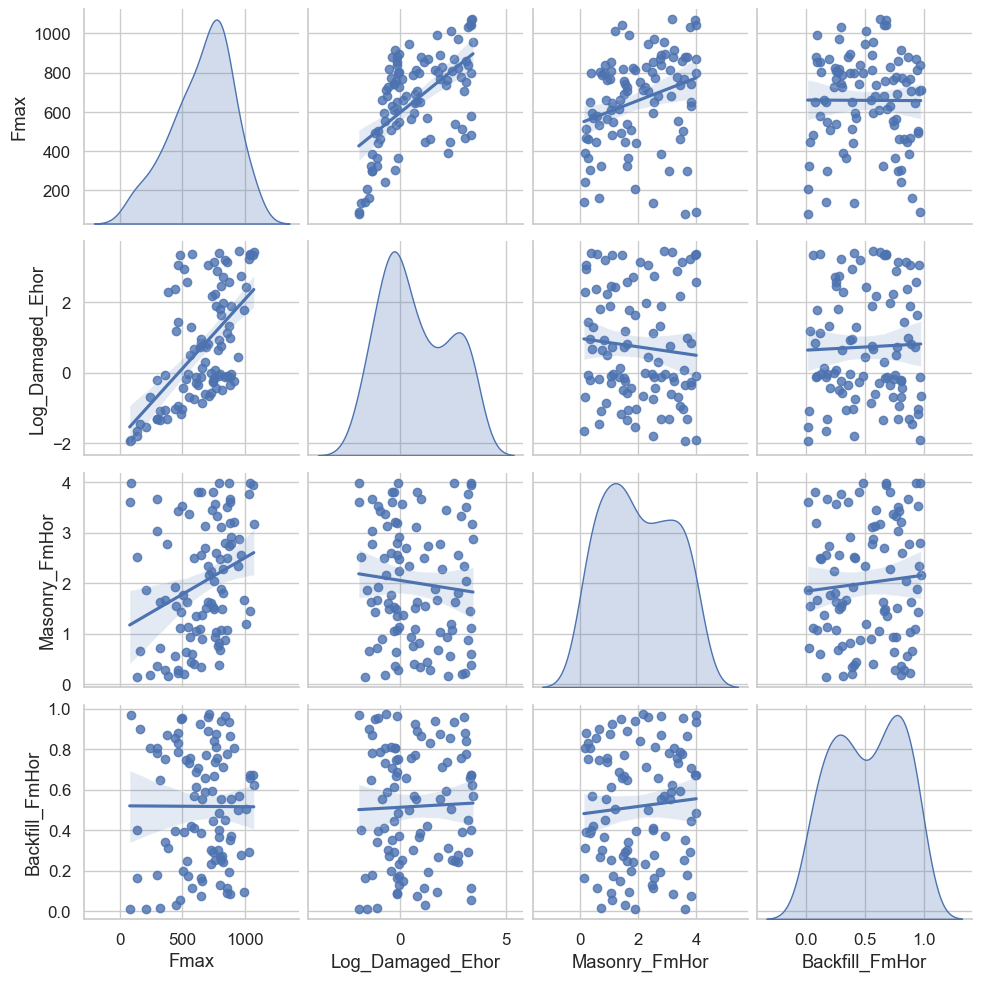

In [106]:
train_dataset = X_train.copy()
train_dataset.insert(0, "Fmax", y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

# Models

In [107]:
models = {}

## Linear

In [108]:
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor, HistGradientBoostingRegressor,
    AdaBoostRegressor
)
from sklearn.linear_model import (
    Ridge, Lasso, ElasticNet, BayesianRidge
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression




# Good defaults that behave well on tabular data
models = {
    # "Ridge": make_pipeline(StandardScaler(with_mean=True, with_std=True),
    #                        Ridge(alpha=1.0, random_state=42)),
    # "Lasso": make_pipeline(StandardScaler(with_mean=True, with_std=True),
    #                        Lasso(alpha=0.001, max_iter=20000, random_state=42)),
    # "ElasticNet": make_pipeline(StandardScaler(with_mean=True, with_std=True),
    #                             ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=20000, random_state=42)),
    # "BayesianRidge": make_pipeline(StandardScaler(with_mean=True, with_std=True),
    #                                BayesianRidge()),
    # "SVR_rbf": make_pipeline(StandardScaler(with_mean=True, with_std=True),
    #                          SVR(C=10.0, epsilon=0.1, kernel="rbf")),
    # "KNN": make_pipeline(StandardScaler(with_mean=True, with_std=True),
    #                      KNeighborsRegressor(n_neighbors=7, weights="distance")),
    # "DecisionTree": DecisionTreeRegressor(random_state=42, min_samples_leaf=3),
    # "RandomForest": RandomForestRegressor(
    #     n_estimators=500, random_state=42, max_features="sqrt", min_samples_leaf=2
    # ),
    # "ExtraTrees": ExtraTreesRegressor(
    #     n_estimators=600, random_state=42, max_features="sqrt", min_samples_leaf=2
    # ),
    # "GradientBoosting": GradientBoostingRegressor(random_state=42),
    # "HistGradientBoosting": make_pipeline(
    #     StandardScaler(),
    #     HistGradientBoostingRegressor(max_depth=6, min_samples_leaf=20, random_state=42
    #     )
    # ),
    # "AdaBoost": AdaBoostRegressor(random_state=42, n_estimators=400, learning_rate=0.05),
    # "PolynomialRegression_2": make_pipeline(
    #     StandardScaler(with_mean=True, with_std=True),
    #     PolynomialFeatures(degree=2, include_bias=False),
    #     LinearRegression()
    # ),
    "PolynomialRegression_3": make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        PolynomialFeatures(degree=3, include_bias=False),
        LinearRegression()
    ),
    "PolynomialRegression_3_Ridge": make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        PolynomialFeatures(degree=3, include_bias=False),
        Ridge(alpha=0.1),
    ),
    "PolynomialRegression_3_Lasso": make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        PolynomialFeatures(degree=3, include_bias=False),
        Lasso(alpha=0.1),
    ),
    "PolynomialRegression_4_Lasso": make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        PolynomialFeatures(degree=4, include_bias=False),
        Lasso(alpha=0.1),
    ),
}

## Others

## Kringing

In [109]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

# Define the kernel
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e2))

# Define the pipeline
models["GaussianProcess"] = make_pipeline(
    StandardScaler(),
    GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=5,
        alpha=0.0,
        random_state=42,
        normalize_y=True
    )
)


## Neural Network

In [110]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

# Simple feedforward neural network for regression
models["NeuralNetwork"] = make_pipeline(
    StandardScaler(),
    MLPRegressor(
        hidden_layer_sizes=(8, 8),
        activation='relu',
        solver='adam',
        learning_rate_init=0.001,
        max_iter=50_000,
        alpha=0.0001,
        # batch_size=64,
        random_state=42,
        # n_iter_no_change=50,
        # early_stopping=True
    )
)

# Training

In [111]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_absolute_error

results = []
fitted = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)

    # 5-fold CV (or fewer if dataset is tiny)
    k = min(5, len(df))
    cv = KFold(n_splits=k, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, scoring="r2", cv=cv)

    results.append({
        "model": name,
        "R2_test": r2,
        "MAE_test": mae,
        "R2_CV_mean": cv_scores.mean(),
        "R2_CV_std": cv_scores.std(),
    })
    fitted[name] = model

results_df = pd.DataFrame(results).sort_values("R2_CV_mean", ascending=False).reset_index(drop=True)

In [112]:
results_df

,model,R2_test,MAE_test,R2_CV_mean,R2_CV_std
0,PolynomialRegression_3_Ridge,0.727367,103.093161,0.730413,0.094238
1,PolynomialRegression_3_Lasso,0.727210,103.148152,0.730252,0.094200
2,PolynomialRegression_3,0.727330,103.087862,0.730151,0.094445
3,PolynomialRegression_4_Lasso,0.662954,120.755033,0.682535,0.141541
4,GaussianProcess,0.667985,119.185798,0.627871,0.103096
5,NeuralNetwork,0.487825,138.124123,0.602487,0.163455


In [135]:
# ── Pick the best by CV R2 and refit on all data ────────────────────────────────
best_name = results_df.iloc[0]["model"]
best_name = "GaussianProcess"
best_model = fitted[best_name]
best_model.fit(X, y)
print(f"\nBest model by CV: {best_name}")


Best model by CV: GaussianProcess


# Plotting

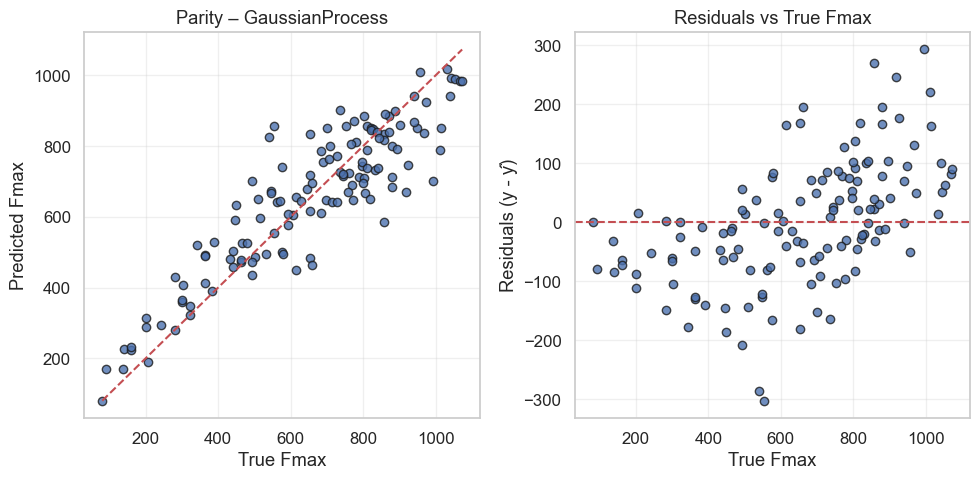

In [136]:
# Predictions and residuals
yhat_all = best_model.predict(X)
residuals = y - yhat_all

# Create two subplots: Parity (left) and Residuals (right)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# ── Parity plot ───────────────────────────────────────────────
axes[0].scatter(y, yhat_all, alpha=0.8, edgecolor='k')
mn, mx = float(np.min(y)), float(np.max(y))
axes[0].plot([mn, mx], [mn, mx], 'r--', lw=1.5)
axes[0].set_title(f"Parity – {best_name}")
axes[0].set_xlabel("True Fmax")
axes[0].set_ylabel("Predicted Fmax")
axes[0].grid(alpha=0.3)

# ── Residuals plot ─────────────────────────────────────────────
axes[1].scatter(y, residuals, alpha=0.8, edgecolor='k')
axes[1].axhline(0, color='r', linestyle='--', lw=1.5)
axes[1].set_title("Residuals vs True Fmax")
axes[1].set_xlabel("True Fmax")
axes[1].set_ylabel("Residuals (y - ŷ)")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [137]:
def plot_poly_coefficients(model, feature_names, top=15):
    """Plot top coefficients (absolute value) from a Polynomial Regression pipeline."""
    try:
        # Get PolynomialFeatures and final regression step
        poly = model.named_steps.get("polynomialfeatures")
        reg = model.named_steps.get("linearregression") or model.named_steps.get("ridge")
        if poly is None or reg is None:
            print("⚠️ Could not find PolynomialFeatures or regressor in pipeline.")
            return

        # Expanded feature names (after polynomial expansion)
        expanded_names = poly.get_feature_names_out(feature_names)

        # Coefficients
        coefs = reg.coef_.ravel()
        idx = np.argsort(np.abs(coefs))[::-1][:top]
        vals = np.abs(coefs[idx])
        labels = expanded_names[idx]

        plt.figure(figsize=(9, 4))
        plt.bar(range(len(idx)), vals)
        plt.xticks(range(len(idx)), labels, rotation=60, ha="right")
        plt.title(f"Top {top} Polynomial Features – {best_name}")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print("Could not extract coefficients:", e)

# ── Optional: feature importances if tree-based (or coefficients if linear) ─────
def plot_top_features(model, names, top=15):
    try:
         # Tree-based models
        importances = model.feature_importances_
        idx = np.argsort(importances)[::-1][:top]
        vals = importances[idx]
        labels = np.array(names)[idx]
    except AttributeError:
        # Linear models in a Pipeline
        try:
            # Try to locate the final estimator in a pipeline
            final = (
                model.named_steps.get("ridge")
                or model.named_steps.get("lasso")
                or model.named_steps.get("elasticnet")
                or model.named_steps.get("bayesianridge")
            )
            coefs = getattr(final, "coef_", None)
            if coefs is None: plot_poly_coefficients(model, names, top)
            idx = np.argsort(np.abs(coefs))[::-1][:top]
            vals = np.abs(coefs)[idx]; labels = np.array(names)[idx]
        except Exception as e:
            print("Could not extract coefficients:", e)
            return

    plt.figure(figsize=(8,4))
    plt.bar(range(len(idx)), vals)
    plt.xticks(range(len(idx)), labels, rotation=60, ha="right")
    plt.title(f"Top {top} features – {best_name}")
    plt.tight_layout(); plt.show()

plot_top_features(best_model, X.columns, top=5)

⚠️ Could not find PolynomialFeatures or regressor in pipeline.
Could not extract coefficients: bad operand type for abs(): 'NoneType'


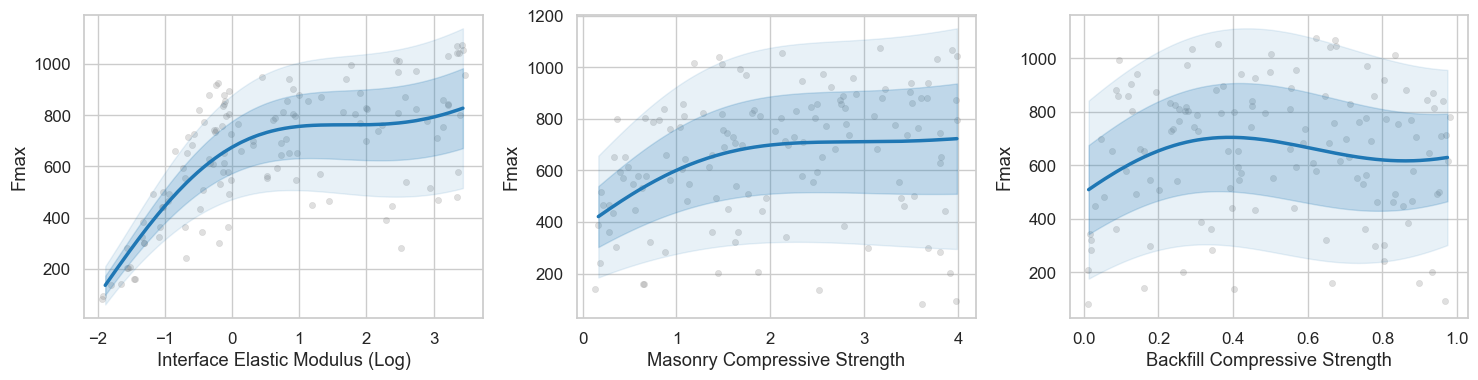

In [138]:
# Pick top features by coefficient magnitude
# importances = best_model.feature_importances_
# idx = np.argsort(importances)[::-1][:9]
top_feats = list(np.array(X.columns)#[idx]
                 )

quantiles = np.linspace(0.01, 0.99, 200)

# Number of random background samples
n_background = 100  # tune: 100–1000 is usually fine

# Draw background rows from X
background = X.sample(n_background, random_state=42).reset_index(drop=True)

records = []

for feat in top_feats:
    xs = np.quantile(X[feat].values, quantiles)

    for v in xs:
        X_tmp = background.copy()
        X_tmp[feat] = v  # only change the target feature

        # Predict all background samples
        yhat = best_model.predict(X_tmp)

        records.append({
            "feature": feat,
            "x": v,
            "yhat_mean": np.mean(yhat),
            "yhat_std": np.std(yhat)
        })

curves = pd.DataFrame(records)

# -------------------- Plot --------------------

sns.set_theme(style="whitegrid", font_scale=1.1)
ncols = 3
nrows = int(np.ceil(len(top_feats) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4 * nrows))

for i, feat in enumerate(top_feats):
    ax = axes.flat[i]
    sub = curves[curves["feature"] == feat].sort_values("x")

    # Scatter actual data for reference
    sns.scatterplot(
        data=df, x=feat, y="Fmax",
        color="gray", alpha=0.25, s=20, ax=ax, edgecolor=None
    )

    # Model-predicted mean trend
    ax.plot(sub["x"], sub["yhat_mean"], color="tab:blue", lw=2.5)

    # Shaded region ±1 std
    ax.fill_between(
        sub["x"],
        sub["yhat_mean"] - sub["yhat_std"],
        sub["yhat_mean"] + sub["yhat_std"],
        color="tab:blue",
        alpha=0.2
    )

    # Shaded region ±2 std
    ax.fill_between(
        sub["x"],
        sub["yhat_mean"] - 2*sub["yhat_std"],
        sub["yhat_mean"] + 2*sub["yhat_std"],
        color="tab:blue",
        alpha=0.1
    )

    ax.set_xlabel(name_map.get(feat,feat))
    ax.set_ylabel("Fmax")

# Hide empty subplots
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes.flat[j])

plt.tight_layout()
plt.show()


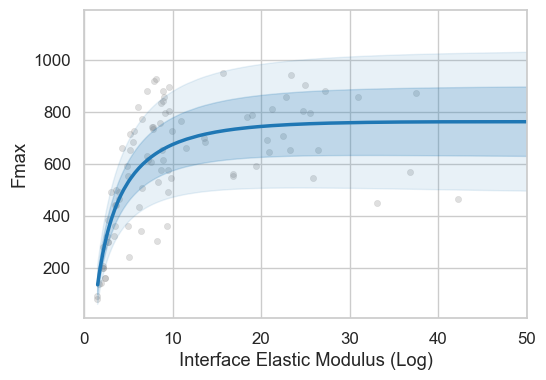

In [139]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

top_feats = list(np.array(X.columns)[[0]])
quantiles = np.linspace(0.01, 0.99, 200)
n_background = 100  # background samples

background = X.sample(n_background, random_state=42).reset_index(drop=True)

records = []

for feat in top_feats:
    xs = np.quantile(X[feat].values, quantiles)

    for v in xs:
        X_tmp = background.copy()
        X_tmp[feat] = v
        yhat = best_model.predict(X_tmp)

        records.append({
            "feature": feat,
            "x": v,
            "yhat_mean": np.mean(yhat),
            "yhat_std": np.std(yhat)
        })

curves = pd.DataFrame(records)

# -------------------- Plot --------------------

sns.set_theme(style="whitegrid", font_scale=1.1)
ncols = 3
nrows = int(np.ceil(len(top_feats) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4 * nrows))

for i, feat in enumerate(top_feats):
    ax = axes.flat[i]
    sub = curves[curves["feature"] == feat].sort_values("x").copy()

    # ✅ Exponentiate the x-axis for both model curve and data
    sub["x_exp"] = np.exp(sub["x"]) * 10
    df_plot = df.copy()
    df_plot[f"{feat}_exp"] = np.exp(df_plot[feat]) * 10

    # Scatter: actual data on real (linear) scale
    sns.scatterplot(
        data=df_plot, x=f"{feat}_exp", y="Fmax",
        color="gray", alpha=0.25, s=20, ax=ax, edgecolor=None
    )

    # Model-predicted mean trend
    ax.plot(sub["x_exp"], sub["yhat_mean"], color="tab:blue", lw=2.5)

    # Shaded region ±1 std
    ax.fill_between(
        sub["x_exp"],
        sub["yhat_mean"] - sub["yhat_std"],
        sub["yhat_mean"] + sub["yhat_std"],
        color="tab:blue", alpha=0.2
    )

    # Shaded region ±2 std
    ax.fill_between(
        sub["x_exp"],
        sub["yhat_mean"] - 2*sub["yhat_std"],
        sub["yhat_mean"] + 2*sub["yhat_std"],
        color="tab:blue", alpha=0.1
    )

    ax.set_xscale("linear")  # now on the true linear scale
    ax.set_xlabel(name_map.get(feat,feat))
    ax.set_ylabel("Fmax")
    ax.set_xlim([0,50])

# Hide empty subplots
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes.flat[j])

plt.tight_layout()
plt.show()


## Eliminating main parameter

In [140]:
main_feat = "Log_Damaged_Ehor"
threshold = 1
df["region"] = np.where(df[main_feat] <= threshold, "Low", "High")

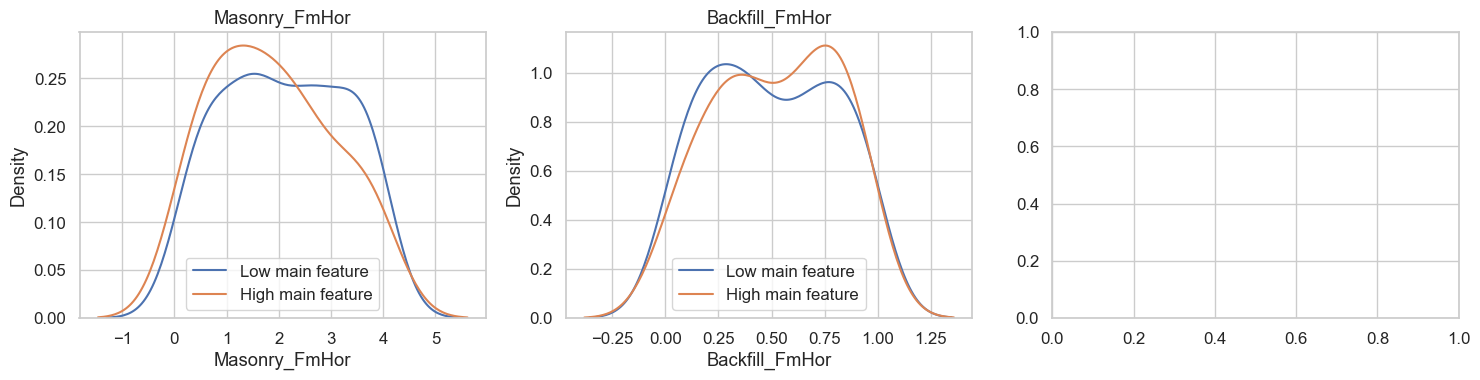

In [141]:
low_region = df["region"] == "Low"
high_region = df["region"] == "High"

others = [f for f in X.columns if f != main_feat]

ncols = 3
nrows = int(np.ceil(len(others)/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4*nrows))

for i, feat in enumerate(others):
    ax = axes.flat[i]
    sns.kdeplot(X.loc[low_region, feat], label="Low main feature", ax=ax)
    sns.kdeplot(X.loc[high_region, feat], label="High main feature", ax=ax)
    ax.set_title(feat)
    ax.legend()

plt.tight_layout()
plt.show()

In [142]:
quantiles = np.linspace(0.01, 0.99, 400)
records = []

for feat in others:
    xs = np.quantile(X[feat].values, quantiles)

    for v in xs:
        for regime, cond in [("low", low_region), ("high", high_region)]:
            background = X.loc[cond].sample(20, random_state=42)
            X_tmp = background.copy()
            X_tmp[feat] = v
            yhat = best_model.predict(X_tmp)
            records.append({
                "feature": feat,
                "x": v,
                "regime": regime,
                "yhat_mean": np.mean(yhat),
                "yhat_std": np.std(yhat)
            })

curves_cond = pd.DataFrame(records)


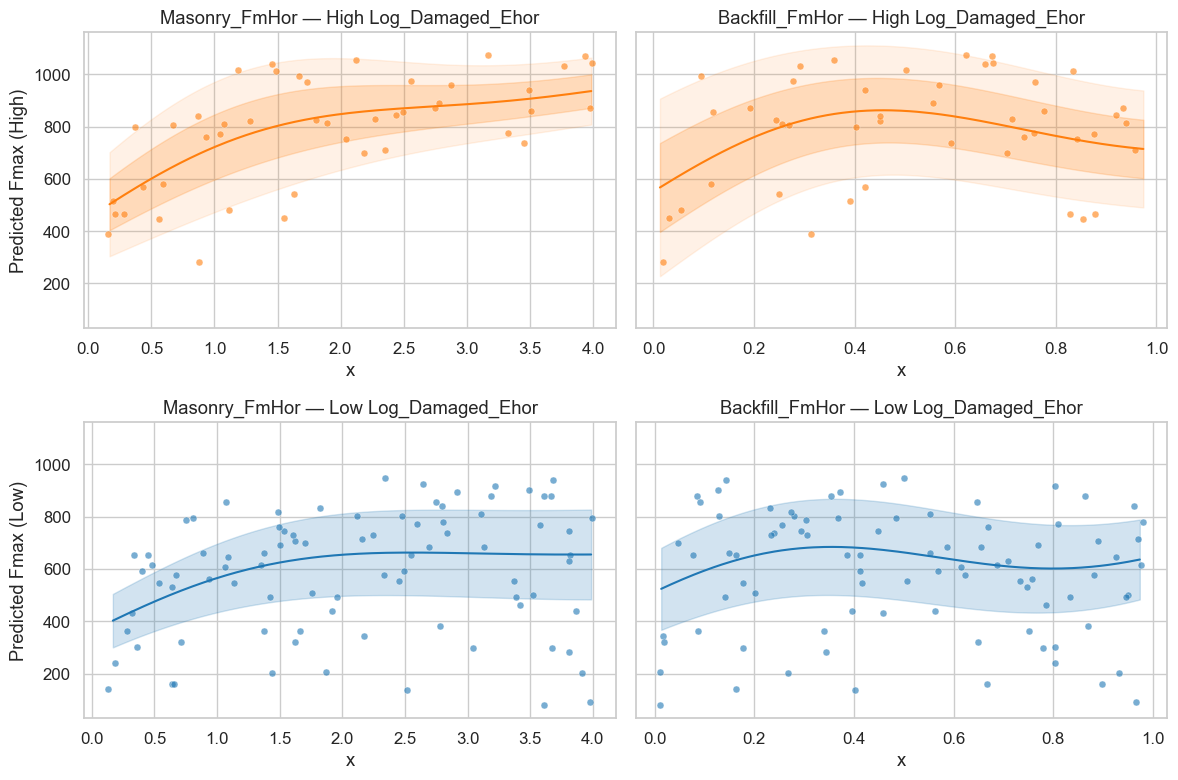

In [143]:
ncols = 2
selected_feats = others[:ncols]

nrows = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 8), sharex=False, sharey=True)

for col_idx, feat in enumerate(selected_feats):
    # --- High region (first row) ---
    ax_high = axes[0, col_idx]
    sub_high = curves_cond[(curves_cond["feature"] == feat) & (curves_cond["regime"] == "high")]

    sns.lineplot(
        data=sub_high, x="x", y="yhat_mean", color="tab:orange", ax=ax_high, label="Model (High)"
    )
    ax_high.fill_between(
        sub_high["x"],
        sub_high["yhat_mean"] - sub_high["yhat_std"],
        sub_high["yhat_mean"] + sub_high["yhat_std"],
        alpha=0.2, color="tab:orange"
    )
    ax_high.fill_between(
        sub_high["x"],
        sub_high["yhat_mean"] - 2*sub_high["yhat_std"],
        sub_high["yhat_mean"] + 2*sub_high["yhat_std"],
        alpha=0.1, color="tab:orange"
    )
    sns.scatterplot(
        data=df[df["region"] == "High"],
        x=feat, y="Fmax",
        color="tab:orange", alpha=0.6, s=25, ax=ax_high, label="Data (High)"
    )
    ax_high.set_title(f"{feat} — High {main_feat}")
    ax_high.legend().set_visible(False)

    # --- Low region (second row) ---
    ax_low = axes[1, col_idx]
    sub_low = curves_cond[(curves_cond["feature"] == feat) & (curves_cond["regime"] == "low")]

    sns.lineplot(
        data=sub_low, x="x", y="yhat_mean", color="tab:blue", ax=ax_low, label="Model (Low)"
    )
    ax_low.fill_between(
        sub_low["x"],
        sub_low["yhat_mean"] - sub_low["yhat_std"],
        sub_low["yhat_mean"] + sub_low["yhat_std"],
        alpha=0.2, color="tab:blue"
    )
    sns.scatterplot(
        data=df[df["region"] == "Low"],
        x=feat, y="Fmax",
        color="tab:blue", alpha=0.6, s=25, ax=ax_low, label="Data (Low)"
    )
    ax_low.set_title(f"{feat} — Low {main_feat}")
    ax_low.legend().set_visible(False)

# Global labels
axes[0, 0].set_ylabel("Predicted Fmax (High)")
axes[1, 0].set_ylabel("Predicted Fmax (Low)")

# Clean up layout
plt.tight_layout()
plt.show()

In [144]:
pipe = models["PolynomialRegression_3"]

# Extract components
# scaler = pipe.named_steps["standardscaler"]
poly = pipe.named_steps["polynomialfeatures"]
linreg = pipe.named_steps["linearregression"]

# Linear regression coefficients and intercept
print("Intercept:", linreg.intercept_)
print("Coefficients:", linreg.coef_)

# Feature names (after PolynomialFeatures)
print("Feature names:", poly.get_feature_names_out())


Intercept: 860.9440031954226
Coefficients: [  92.98483265   31.76336463  -55.274168   -122.32529173   26.0872443
    7.86221431  -64.27290621   11.9943659   -40.80757189   75.2888952
  -15.99279058   -0.86494342   -0.52791521   -9.44735177  -49.29795713
   38.20754384  -12.18898362   14.41505897   36.38806432]
Feature names: ['x0' 'x1' 'x2' 'x0^2' 'x0 x1' 'x0 x2' 'x1^2' 'x1 x2' 'x2^2' 'x0^3'
 'x0^2 x1' 'x0^2 x2' 'x0 x1^2' 'x0 x1 x2' 'x0 x2^2' 'x1^3' 'x1^2 x2'
 'x1 x2^2' 'x2^3']


In [145]:
pipe = models["PolynomialRegression_3_Lasso"]

# scaler = pipe.named_steps["standardscaler"]
poly   = pipe.named_steps["polynomialfeatures"]
lasso  = pipe.named_steps["lasso"]

print("Intercept:", lasso.intercept_)
print("Coefficients:", lasso.coef_)
print("Feature names:", poly.get_feature_names_out())


Intercept: 860.3212644224111
Coefficients: [  91.91275381   31.22287281  -54.2969491  -122.08302447   25.84783379
    7.68072345  -64.11737514   11.91603658  -40.63713977   75.34499216
  -15.63331929   -0.6532649    -0.22606081   -9.4490307   -48.82228575
   38.222887    -12.41011319   14.3944839    35.82001481]
Feature names: ['x0' 'x1' 'x2' 'x0^2' 'x0 x1' 'x0 x2' 'x1^2' 'x1 x2' 'x2^2' 'x0^3'
 'x0^2 x1' 'x0^2 x2' 'x0 x1^2' 'x0 x1 x2' 'x0 x2^2' 'x1^3' 'x1^2 x2'
 'x1 x2^2' 'x2^3']
